<a href="https://colab.research.google.com/github/Mike-Gottrup/Car-Wrap-cut-Calculator/blob/main/Car%20Wra%C3%A5%20Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial estimated foil length: 17522 mm


<ipython-input-16-46e6fc02ca3d>:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))


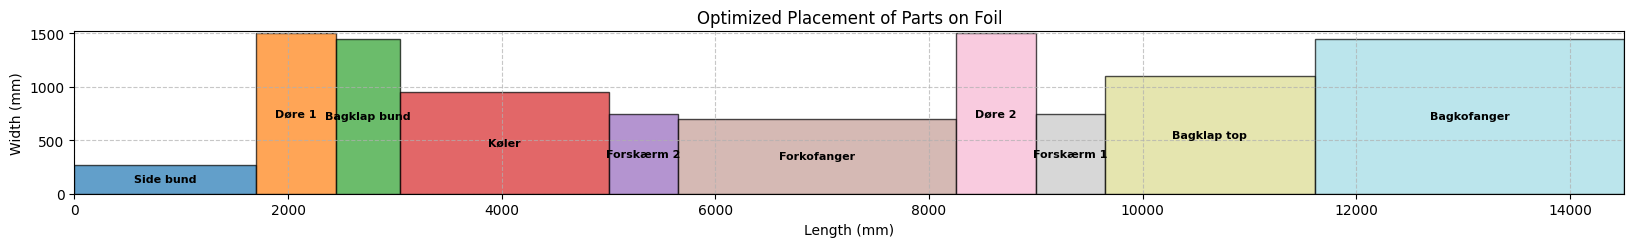


Results:
Total area of parts: 14587500.00 square millimeters
Initial estimated length: 17522 mm
Actual used length: 14510 mm
Total waste: 7467700.00 square millimeters
Waste percentage: 33.86%

Optimized placement of parts:
Side bund: (0, 0) to (1700, 270)
Døre 1: (1700, 0) to (2450, 1500)
Bagklap bund: (2450, 0) to (3050, 1450)
Køler: (3050, 0) to (5000, 950)
Forskærm 2: (5000, 0) to (5650, 750)
Forkofanger: (5650, 0) to (8250, 700)
Døre 2: (8250, 0) to (9000, 1500)
Forskærm 1: (9000, 0) to (9650, 750)
Bagklap top: (9650, 0) to (11610, 1100)
Bagkofanger: (11610, 0) to (14510, 1450)


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import time

class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_y = folie_bredde
    best_x = folie_længde
    placed = False

    for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
        for x, y in [(placed_rect.x + placed_rect.width, placed_rect.y),
                     (placed_rect.x, placed_rect.y + placed_rect.height)]:
            if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                if y < best_y or (y == best_y and x < best_x):
                    best_x, best_y = x, y
                    placed = True

    if placed:
        rect.x, rect.y = best_x, best_y
        placed_rects.append(rect)
    return placed

def pack_rectangles(rectangles, folie_bredde, rotation_allowed=True):
    placed_rects = []
    for rect in rectangles:
        if not place_rectangle(rect, placed_rects, folie_bredde, float('inf')):
            if rotation_allowed and rect.width < rect.height:
                rect.width, rect.height = rect.height, rect.width
                rect.rotated = True
                if not place_rectangle(rect, placed_rects, folie_bredde, float('inf')):
                    rect.width, rect.height = rect.height, rect.width
                    rect.rotated = False
                    return None
    return placed_rects

def optimize_packing(dele, folie_bredde, max_iterations=1000):
    best_packing = None
    best_length = float('inf')

    for _ in range(max_iterations):
        random.shuffle(dele)
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        packing = pack_rectangles(rectangles, folie_bredde)

        if packing:
            used_length = max(rect.x + rect.width for rect in packing)
            if used_length < best_length:
                best_length = used_length
                best_packing = packing

    return best_packing, best_length

def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage
folie_bredde = 1520  # Width of the foil roll in millimeters

dele = [
    ("Forkofanger", 2600, 700),
    ("Bagkofanger", 2900, 1450),
    ("Tag", 3500, 1530),
    ("Køler", 1950, 950),
    ("Side top", 2790, 1530),
    ("Side bund", 1700, 270),
    ("Forskærm 1", 650, 750),
    ("Forskærm 2", 650, 750),
    ("Bagklap top", 1960, 1100),
    ("Døre 1", 750, 1500),
    ("Døre 2", 750, 1500),
    ("Bagklap bund", 600, 1450)
]

# Calculate initial estimated length
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimize packing
best_packing, used_length = optimize_packing(dele, folie_bredde, max_iterations=10000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")
else:
    print("Failed to find a valid packing arrangement.")

Initial estimated foil length: 17522 mm


<ipython-input-31-006220a9a534>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))


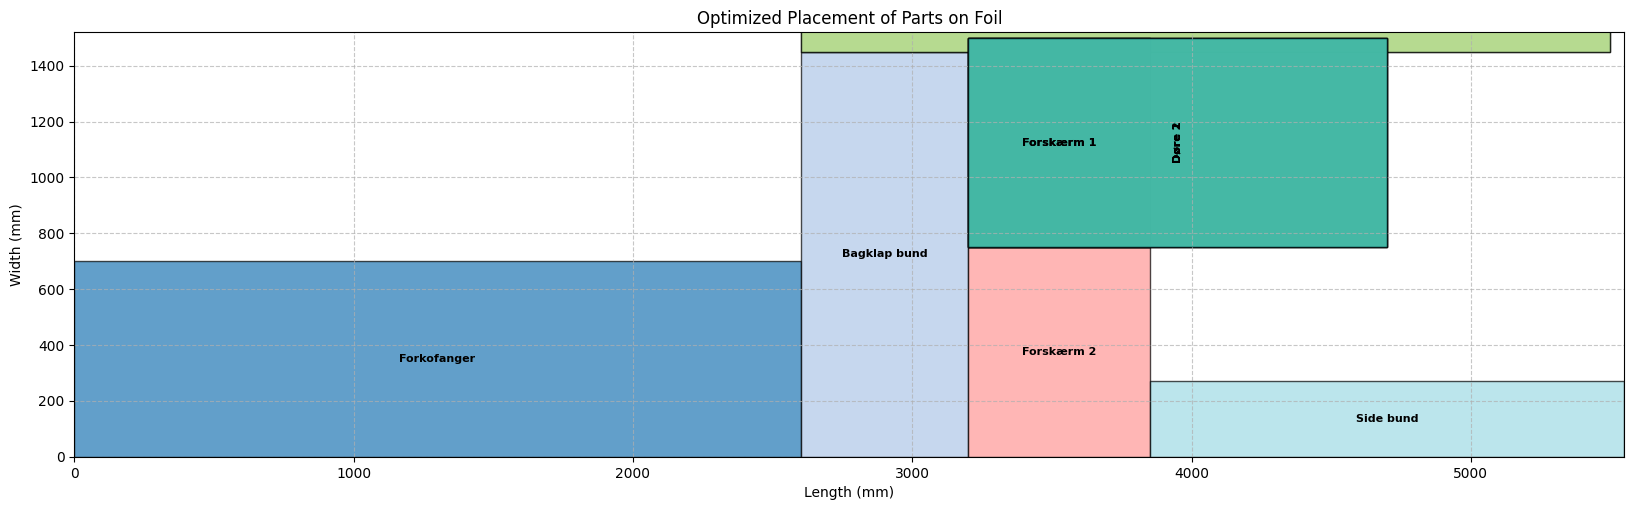


Results:
Total area of parts: 17521500.00 square millimeters
Initial estimated length: 17522 mm
Actual used length: 5550 mm
Total waste: -9085500.00 square millimeters
Waste percentage: -107.70%

Optimized placement of parts:
Forkofanger: (0, 0) to (2600, 700)
Bagklap bund: (2600, 0) to (3200, 1450)
Bagkofanger: (2600, 1450) to (5500, 2900)
Bagkofanger: (2600, 1450) to (5500, 2900)
Forskærm 2: (3200, 0) to (3850, 750)
Forskærm 1: (3200, 750) to (3850, 1500)
Forskærm 1: (3200, 750) to (3850, 1500)
Døre 1: (3200, 750) to (4700, 1500) (rotated)
Døre 1: (3200, 750) to (4700, 1500) (rotated)
Døre 2: (3200, 750) to (4700, 1500) (rotated)
Døre 2: (3200, 750) to (4700, 1500) (rotated)
Side bund: (3850, 0) to (5550, 270)


In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_placement = None
    placed = False

    for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
        for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y), (placed_rect.x, placed_rect.y + placed_rect.height)]:
            if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                if y < best_y or (y == best_y and x < best_x):
                    best_x, best_y = x, y
                    best_placement = (x, y)
                    placed = True

    if placed:
        rect.x, rect.y = best_placement
        placed_rects.append(rect)
    return placed

def can_stack(rect1, rect2, folie_bredde, folie_længde):
    if rect1.x == rect2.x and rect1.y + rect1.height == rect2.y:
        if rect1.width == rect2.width:
            return can_place(rect2, rect1.x, rect1.y + rect1.height, [], folie_bredde, folie_længde)
    if rect1.y == rect2.y and rect1.x + rect1.width == rect2.x:
        if rect1.height == rect2.height:
            return can_place(rect2, rect1.x + rect1.width, rect1.y, [], folie_bredde, folie_længde)
    return False

def place_rectangles_with_stack(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        if not place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
            if rect.width < rect.height:
                rect.width, rect.height = rect.height, rect.width
                rect.rotated = True
                if not place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
                    rect.width, rect.height = rect.height, rect.width
                    rect.rotated = False
                    return None
        # Attempt to stack the rectangle
        for placed in placed_rects:
            if can_stack(placed, rect, folie_bredde, folie_længde):
                rect.x, rect.y = placed.x, placed.y + placed.height
                placed_rects.append(rect)
                break
    return placed_rects

def optimize_packing(dele, folie_bredde, max_iterations=1000):
    best_packing = None
    best_length = float('inf')

    for _ in range(max_iterations):
        random.shuffle(dele)
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        packing = place_rectangles_with_stack(rectangles, folie_bredde, float('inf'))

        if packing:
            used_length = max(rect.x + rect.width for rect in packing)
            if used_length < best_length:
                best_length = used_length
                best_packing = packing

    return best_packing, best_length

def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage
folie_bredde = 1520  # Width of the foil roll in millimeters

dele = [
    ("Forkofanger", 2600, 700),
    ("Bagkofanger", 2900, 1450),
    ("Tag", 3500, 1530),
    ("Køler", 1950, 950),
    ("Side top", 2790, 1530),
    ("Side bund", 1700, 270),
    ("Forskærm 1", 650, 750),
    ("Forskærm 2", 650, 750),
    ("Bagklap top", 1960, 1100),
    ("Døre 1", 750, 1500),
    ("Døre 2", 750, 1500),
    ("Bagklap bund", 600, 1450)
]

# Calculate initial estimated length
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimize packing
best_packing, used_length = optimize_packing(dele, folie_bredde, max_iterations=10000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")
else:
    print("Failed to find a valid packing arrangement.")


In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

def can_stack(rect1, rect2):
    if rect1.x == rect2.x and rect1.y + rect1.height == rect2.y:
        if rect1.width == rect2.width:
            return True
    if rect1.y == rect2.y and rect1.x + rect1.width == rect2.x:
        if rect1.height == rect2.height:
            return True
    return False

def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.width, rect.height = rect.height, rect.width

        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y), (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.width, rect.height = rect.height, rect.width

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

def place_rectangles_with_stack(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        if not place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
            return None
        # Attempt to stack the rectangle
        for placed in placed_rects:
            for rotated in [False, True]:
                if rotated:
                    rect.width, rect.height = rect.height, rect.width
                if can_stack(placed, rect):
                    rect.x, rect.y = placed.x, placed.y + placed.height
                    rect.rotated = rotated
                    placed_rects.append(rect)
                    break
            if rect in placed_rects:
                break
    return placed_rects

def optimize_packing(dele, folie_bredde, max_iterations=1000):
    best_packing = None
    best_length = float('inf')

    for _ in range(max_iterations):
        random.shuffle(dele)
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        packing = place_rectangles_with_stack(rectangles, folie_bredde, float('inf'))

        if packing:
            used_length = max(rect.x + rect.width for rect in packing)
            if used_length < best_length:
                best_length = used_length
                best_packing = packing

    return best_packing, best_length

def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage
folie_bredde = 1520  # Width of the foil roll in millimeters

dele = [
    ("Forkofanger", 2600, 700),
    ("Bagkofanger", 2900, 1450),
    ("Tag", 3500, 1530),
    ("Køler", 1950, 950),
    ("Side top", 2790, 1530),
    ("Side bund", 1700, 270),
    ("Forskærm 1", 650, 750),
    ("Forskærm 2", 650, 750),
    ("Bagklap top", 1960, 1100),
    ("Døre 1", 750, 1500),
    ("Døre 2", 750, 1500),
    ("Bagklap bund", 600, 1450)
]

# Calculate initial estimated length
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimize packing
best_packing, used_length = optimize_packing(dele, folie_bredde, max_iterations=10000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")
else:
    print("Failed to find a valid packing arrangement.")


Initial estimated foil length: 17522 mm
Failed to find a valid packing arrangement.


In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

def pack_rectangles(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        placed = place_rectangle(rect, placed_rects, folie_bredde, folie_længde)
        if not placed:
            return None
    return placed_rects

def create_initial_population(dele, population_size):
    return [random.sample(dele, len(dele)) for _ in range(population_size)]

def fitness_function(rectangles, folie_bredde, folie_længde):
    packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
    if packing:
        return max(rect.x + rect.width for rect in packing)
    # Return a large number when packing fails to avoid NoneType error
    return float('inf')

def mutate(individual):
    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

def crossover(parent1, parent2):
    split = random.randint(1, len(parent1) - 1)
    child1 = parent1[:split] + [item for item in parent2 if item not in parent1[:split]]
    child2 = parent2[:split] + [item for item in parent1 if item not in parent2[:split]]
    return child1, child2

def genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1):


        current_best = population[0]
        current_fitness = fitness_function([Rectangle(length, width, name) for name, length, width in current_best], folie_bredde, folie_længde)

        if current_fitness < best_fitness:
            best_fitness = current_fitness
            best_individual = current_best

        new_population = [best_individual]

        while len(new_population) < population_size:
            parent1, parent2 = random.choices(population, k=2)
            child1, child2 = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)
            new_population.extend([child1, child2])

        population = new_population

    best_packing = [Rectangle(length, width, name) for name, length, width in best_individual]
    return pack_rectangles(best_packing, folie_bredde, folie_længde), best_fitness

def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage
folie_bredde = 1520  # Width of the foil roll in millimeters
folie_længde = 25000  # Maximum length of the foil roll in millimeters

dele = [
    ("Forkofanger", 2600, 700),
    ("Bagkofanger", 2900, 1450),
    ("Tag", 3500, 1530),
    ("Køler", 1950, 950),
    ("Side top", 2790, 1530),
    ("Side bund", 1700, 270),
    ("Forskærm 1", 650, 750),
    ("Forskærm 2", 650, 750),
    ("Bagklap top", 1960, 1100),
    ("Døre 1", 750, 1500),
    ("Døre 2", 750, 1500),
    ("Bagklap bund", 600, 1450)
]

# Calculate initial estimated length
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimize packing
best_packing, used_length = genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")
else:
    print("Failed to find a valid packing arrangement.")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 110)

Initial estimated foil length: 14479 mm


<ipython-input-44-0da75bf2a315>:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))


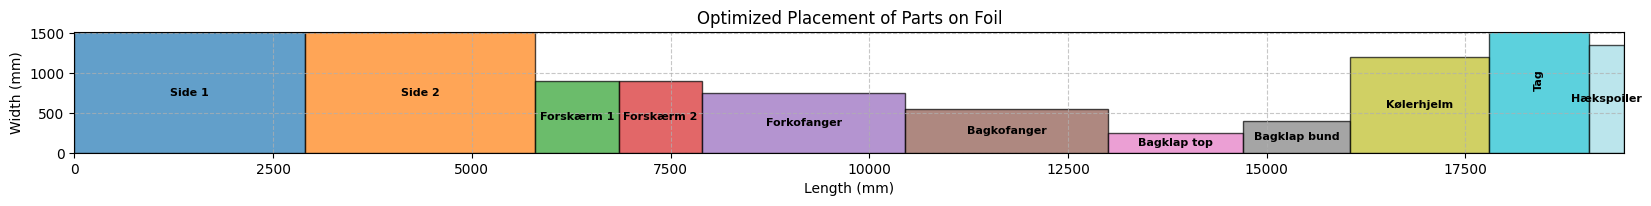


Results:
Total area of parts: 20006000.00 square millimeters
Initial estimated length: 14479 mm
Actual used length: 19500 mm
Total waste: 9634000.00 square millimeters
Waste percentage: 32.50%

Optimized placement of parts:
Side 1: (0, 0) to (2900, 1520)
Side 2: (2900, 0) to (5800, 1520)
Forskærm 1: (5800, 0) to (6850, 900)
Forskærm 2: (6850, 0) to (7900, 900)
Forkofanger: (7900, 0) to (10450, 750)
Bagkofanger: (10450, 0) to (13000, 550)
Bagklap top: (13000, 0) to (14700, 250)
Bagklap bund: (14700, 0) to (16050, 400)
Kølerhjelm: (16050, 0) to (17800, 1200)
Tag: (17800, 0) to (19050, 1850) (rotated)
Hækspoiler: (19050, 0) to (19500, 1350)


In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

def pack_rectangles(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        placed = place_rectangle(rect, placed_rects, folie_bredde, folie_længde)
        if not placed:
            return None
    return placed_rects
def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness
folie_bredde = 1520  # Width of the foil roll in millimeters
folie_længde = 25000  # Maximum length of the foil roll in millimeters

dele = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350)
]

# Calculate initial estimated length
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimize packing using Simulated Annealing
best_packing, used_length = simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")
else:
    print("Failed to find a valid packing arrangement.")
def genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1):
    def create_individual():
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        random.shuffle(rectangles)
        return rectangles

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    def mutate(individual):
        idx1, idx2 = random.sample(range(len(individual)), 2)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    def crossover(parent1, parent2):
        split = random.randint(1, len(parent1) - 1)
        return parent1[:split] + parent2[split:]

    population = [create_individual() for _ in range(population_size)]
    current_best = min(population, key=fitness_function)
    best_packing = None
    best_length = fitness_function(current_best)

    for generation in range(generations):
        population.sort(key=fitness_function)
        if fitness_function(population[0]) < best_length:
            best_length = fitness_function(population[0])
            best_packing = pack_rectangles(population[0], folie_bredde, folie_længde)

        new_population = population[:2]  # Keep the best two

        for _ in range(population_size - 2):
            parent1, parent2 = random.choices(population[:10], k=2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child)
            new_population.append(child)

        population = new_population

    return best_packing, best_length
def tabu_search(dele, folie_bredde, folie_længde, max_iterations=1000, tabu_size=10):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def neighborhood_solution(solution):
        neighbor = solution.copy()
        random_swap(neighbor)
        return neighbor

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    tabu_list = []

    for iteration in range(max_iterations):
        neighbor = neighborhood_solution(current_solution)
        neighbor_fitness = fitness_function(neighbor)

        if neighbor_fitness < best_fitness:
            best_fitness = neighbor_fitness
            best_solution = neighbor.copy()

        if len(tabu_list) >= tabu_size:
            tabu_list.pop(0)
        tabu_list.append(current_solution)

        if neighbor not in tabu_list:
            current_solution = neighbor
            current_fitness = neighbor_fitness

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness


Initial estimated foil length: 14479 mm


<ipython-input-47-7159c6a143a3>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))


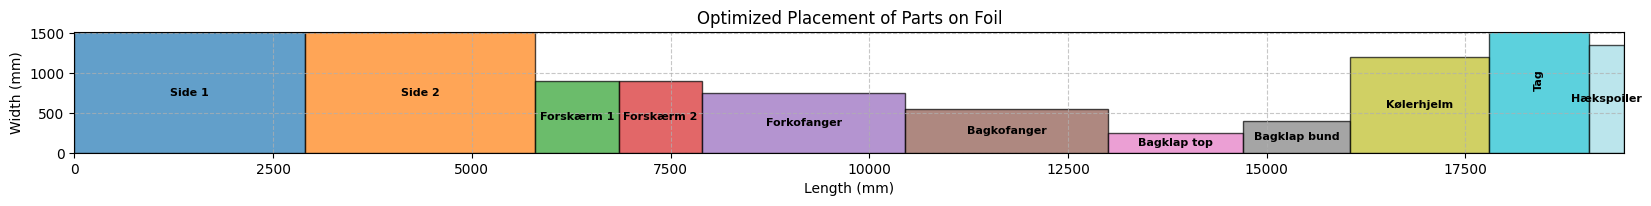


Results:
Total area of parts: 20006000.00 square millimeters
Initial estimated length: 14479 mm
Actual used length: 19500 mm
Total waste: 9634000.00 square millimeters
Waste percentage: 32.50%

Optimized placement of parts:
Side 1: (0, 0) to (2900, 1520)
Side 2: (2900, 0) to (5800, 1520)
Forskærm 1: (5800, 0) to (6850, 900)
Forskærm 2: (6850, 0) to (7900, 900)
Forkofanger: (7900, 0) to (10450, 750)
Bagkofanger: (10450, 0) to (13000, 550)
Bagklap top: (13000, 0) to (14700, 250)
Bagklap bund: (14700, 0) to (16050, 400)
Kølerhjelm: (16050, 0) to (17800, 1200)
Tag: (17800, 0) to (19050, 1850) (rotated)
Hækspoiler: (19050, 0) to (19500, 1350)


In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

# Definerer rektangelklassen
class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

    def area(self):
        return self.width * self.height

    def __repr__(self):
        return f"{self.name}: ({self.width}x{self.height})"

# Kontrollerer om et rektangel kan placeres på et givent sted
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

# Placerer et rektangel på det bedste mulige sted
def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

# Håndterer `Bagklap top` og `Bagklap bund`, enten placerer dem ovenpå hinanden eller side om side
def handle_bagklap(dele):
    for i, (name, length, width) in enumerate(dele):
        if name == "Bagklap top":
            bagklap_top = Rectangle(length, width, name)
        elif name == "Bagklap bund":
            bagklap_bund = Rectangle(length, width, name)

    if bagklap_top.width == bagklap_bund.width:
        # Forsøg at placere Bagklap top og Bagklap bund ovenpå hinanden
        bagklap_top.y = 0
        bagklap_bund.y = bagklap_top.height

        if bagklap_top.x == bagklap_bund.x:
            dele.remove(("Bagklap top", bagklap_top.width, bagklap_top.height))
            dele.remove(("Bagklap bund", bagklap_bund.width, bagklap_bund.height))
            dele.append(("Bagklap", bagklap_top.width, bagklap_top.height + bagklap_bund.height))

    return dele

# Placerer rektanglerne og prøver stabling hvis placering fejler
def pack_rectangles(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        placed = place_rectangle(rect, placed_rects, folie_bredde, folie_længde)
        if not placed:
            return None
    return placed_rects

# Plotter placeringen af rektanglerne
def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Simulated Annealing algoritmen til at optimere pakningen
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    def place_with_stacking(rectangles, folie_bredde, folie_længde):
        placed_rects = []
        for rect in rectangles:
            placed = place_rectangle(rect, placed_rects, folie_bredde, folie_længde)
            if not placed:
                # Prøver at stable hvis placering fejler
                placed = False
                for placed_rect in placed_rects:
                    if place_on_top(placed_rect, rect, placed_rects, folie_bredde, folie_længde):
                        placed = True
                        break
                if not placed:
                    return None
        return placed_rects

    # Initial solution
    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Genetisk algoritme til at optimere pakningen
def genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1):
    def create_individual():
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        random.shuffle(rectangles)
        return rectangles

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    def mutate(individual):
        idx1, idx2 = random.sample(range(len(individual)), 2)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    def crossover(parent1, parent2):
        split = random.randint(1, len(parent1) - 1)
        return parent1[:split] + parent2[split:]

    population = [create_individual() for _ in range(population_size)]
    current_best = min(population, key=fitness_function)
    best_packing = None
    best_length = fitness_function(current_best)

    for generation in range(generations):
        population.sort(key=fitness_function)
        if fitness_function(population[0]) < best_length:
            best_length = fitness_function(population[0])
            best_packing = pack_rectangles(population[0], folie_bredde, folie_længde)

        new_population = population[:2]  # Keep the best two

        for _ in range(population_size - 2):
            parent1, parent2 = random.choices(population[:10], k=2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child)
            new_population.append(child)

        population = new_population

    return best_packing, best_length

# Tabu Search algoritmen til at optimere pakningen
def tabu_search(dele, folie_bredde, folie_længde, max_iterations=1000, tabu_size=10):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def neighborhood_solution(solution):
        neighbor = solution.copy()
        random_swap(neighbor)
        return neighbor

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    tabu_list = []

    for iteration in range(max_iterations):
        neighbor = neighborhood_solution(current_solution)
        neighbor_fitness = fitness_function(neighbor)

        if neighbor_fitness < best_fitness:
            best_fitness = neighbor_fitness
            best_solution = neighbor.copy()

        if len(tabu_list) >= tabu_size:
            tabu_list.pop(0)
        tabu_list.append(current_solution)

        if neighbor not in tabu_list:
            current_solution = neighbor
            current_fitness = neighbor_fitness

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Opdatering af `dele` listen
dele = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350)
]

# Håndterer Bagklap top og Bagklap bund
dele = handle_bagklap(dele)

# Beregner den initiale anslåede længde af folien
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimering af pakning ved hjælp af Simulated Annealing
best_packing, used_length = simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

else:
    print("Failed to find a valid packing arrangement.")


Initial estimated foil length: 14479 mm


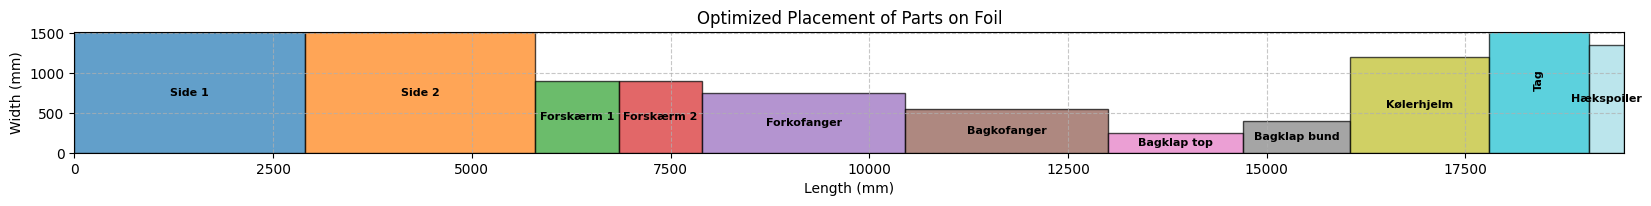


Results:
Total area of parts: 20006000.00 square millimeters
Initial estimated length: 14479 mm
Actual used length: 19500 mm
Total waste: 9634000.00 square millimeters
Waste percentage: 32.50%

Optimized placement of parts:
Side 1: (0, 0) to (2900, 1520)
Side 2: (2900, 0) to (5800, 1520)
Forskærm 1: (5800, 0) to (6850, 900)
Forskærm 2: (6850, 0) to (7900, 900)
Forkofanger: (7900, 0) to (10450, 750)
Bagkofanger: (10450, 0) to (13000, 550)
Bagklap top: (13000, 0) to (14700, 250)
Bagklap bund: (14700, 0) to (16050, 400)
Kølerhjelm: (16050, 0) to (17800, 1200)
Tag: (17800, 0) to (19050, 1850) (rotated)
Hækspoiler: (19050, 0) to (19500, 1350)


In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

# Definerer rektangelklassen
class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

    def area(self):
        return self.width * self.height

    def __repr__(self):
        return f"{self.name}: ({self.width}x{self.height})"

# Kontrollerer om et rektangel kan placeres på et givent sted
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

# Placerer et rektangel på det bedste mulige sted
def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

# Håndterer `Bagklap top` og `Bagklap bund`, placerer dem ovenpå hinanden
def handle_bagklap(dele):
    for i, (name, length, width) in enumerate(dele):
        if name == "Bagklap top":
            bagklap_top = Rectangle(length, width, name)
        elif name == "Bagklap bund":
            bagklap_bund = Rectangle(length, width, name)

    if bagklap_top.width == bagklap_bund.width:
        # Forsøg at placere Bagklap top og Bagklap bund ovenpå hinanden
        bagklap_top.y = 0
        bagklap_bund.y = bagklap_top.height

        if bagklap_top.x == bagklap_bund.x:
            dele.remove(("Bagklap top", bagklap_top.width, bagklap_top.height))
            dele.remove(("Bagklap bund", bagklap_bund.width, bagklap_bund.height))
            dele.append(("Bagklap", bagklap_top.width, bagklap_top.height + bagklap_bund.height))

    return dele

# Placerer rektanglerne og prøver stabling hvis placering fejler
def pack_rectangles(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        placed = place_rectangle(rect, placed_rects, folie_bredde, folie_længde)
        if not placed:
            # Prøver at stable hvis placering fejler
            placed = False
            for placed_rect in placed_rects:
                if place_on_top(placed_rect, rect, placed_rects, folie_bredde, folie_længde):
                    placed = True
                    break
            if not placed:
                return None
    return placed_rects

# Placerer et rektangel ovenpå et andet rektangel
def place_on_top(base_rect, rect, placed_rects, folie_bredde, folie_længde):
    x = base_rect.x
    y = base_rect.y + base_rect.height
    if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
        rect.x, rect.y = x, y
        placed_rects.append(rect)
        return True
    return False

# Plotter placeringen af rektanglerne
def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    cmap = plt.colormaps['tab20']  # Opdateret til ny metode i Matplotlib 3.7
    colors = cmap(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Simulated Annealing algoritmen til at optimere pakningen
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    # Initial solution
    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Genetisk algoritme til at optimere pakningen
def genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1):
    def create_individual():
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        random.shuffle(rectangles)
        return rectangles

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    def mutate(individual):
        idx1, idx2 = random.sample(range(len(individual)), 2)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    def crossover(parent1, parent2):
        split = random.randint(1, len(parent1) - 1)
        return parent1[:split] + parent2[split:]

    population = [create_individual() for _ in range(population_size)]
    current_best = min(population, key=fitness_function)
    best_packing = None
    best_length = fitness_function(current_best)

    for generation in range(generations):
        population.sort(key=fitness_function)
        if fitness_function(population[0]) < best_length:
            best_length = fitness_function(population[0])
            best_packing = pack_rectangles(population[0], folie_bredde, folie_længde)

        new_population = population[:2]  # Keep the best two

        for _ in range(population_size - 2):
            parent1, parent2 = random.choices(population[:10], k=2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child)
            new_population.append(child)

        population = new_population

    return best_packing, best_length

# Tabu Search algoritmen til at optimere pakningen
def tabu_search(dele, folie_bredde, folie_længde, max_iterations=1000, tabu_size=10):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def neighborhood_solution(solution):
        neighbor = solution.copy()
        random_swap(neighbor)
        return neighbor

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    tabu_list = []

    for iteration in range(max_iterations):
        neighbor = neighborhood_solution(current_solution)
        neighbor_fitness = fitness_function(neighbor)

        if neighbor_fitness < best_fitness:
            best_fitness = neighbor_fitness
            best_solution = neighbor.copy()

        if len(tabu_list) >= tabu_size:
            tabu_list.pop(0)
        tabu_list.append(current_solution)

        if neighbor not in tabu_list:
            current_solution = neighbor
            current_fitness = neighbor_fitness

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Opdatering af `dele` listen
dele = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350)
]

# Håndterer Bagklap top og Bagklap bund
dele = handle_bagklap(dele)

# Beregner den initiale anslåede længde af folien
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimering af pakning ved hjælp af Simulated Annealing
best_packing, used_length = simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

else:
    print("Failed to find a valid packing arrangement.")


Initial estimated foil length: 14479 mm


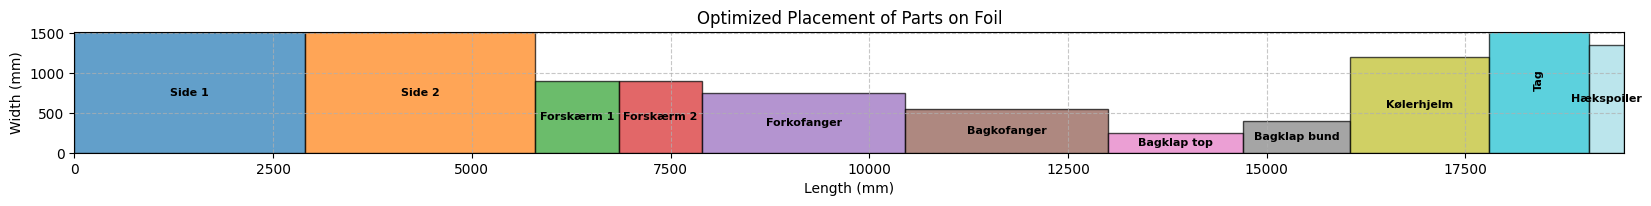


Results:
Total area of parts: 20006000.00 square millimeters
Initial estimated length: 14479 mm
Actual used length: 19500 mm
Total waste: 9634000.00 square millimeters
Waste percentage: 32.50%

Optimized placement of parts:
Side 1: (0, 0) to (2900, 1520)
Side 2: (2900, 0) to (5800, 1520)
Forskærm 1: (5800, 0) to (6850, 900)
Forskærm 2: (6850, 0) to (7900, 900)
Forkofanger: (7900, 0) to (10450, 750)
Bagkofanger: (10450, 0) to (13000, 550)
Bagklap top: (13000, 0) to (14700, 250)
Bagklap bund: (14700, 0) to (16050, 400)
Kølerhjelm: (16050, 0) to (17800, 1200)
Tag: (17800, 0) to (19050, 1850) (rotated)
Hækspoiler: (19050, 0) to (19500, 1350)


In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

# Definerer rektangelklassen
class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

    def area(self):
        return self.width * self.height

    def __repr__(self):
        return f"{self.name}: ({self.width}x{self.height})"

# Kontrollerer om et rektangel kan placeres på et givent sted
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

# Placerer et rektangel på det bedste mulige sted
def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

# Håndterer `Bagklap top` og `Bagklap bund`, placerer dem ovenpå hinanden
def handle_bagklap(dele):
    bagklap_top = None
    bagklap_bund = None

    for i, (name, length, width) in enumerate(dele):
        if name == "Bagklap top":
            bagklap_top = Rectangle(length, width, name)
        elif name == "Bagklap bund":
            bagklap_bund = Rectangle(length, width, name)

    if bagklap_top and bagklap_bund and bagklap_top.width == bagklap_bund.width:
        # Forsøg at placere Bagklap top og Bagklap bund ovenpå hinanden
        bagklap_top.y = 0
        bagklap_bund.y = bagklap_top.height

        dele.remove(("Bagklap top", bagklap_top.width, bagklap_top.height))
        dele.remove(("Bagklap bund", bagklap_bund.width, bagklap_bund.height))
        dele.append(("Bagklap", bagklap_top.width, bagklap_top.height + bagklap_bund.height))

    return dele

# Placerer rektanglerne og prøver stabling hvis placering fejler
def pack_rectangles(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        placed = place_rectangle(rect, placed_rects, folie_bredde, folie_længde)
        if not placed:
            # Prøver at stable hvis placering fejler
            placed = False
            for placed_rect in placed_rects:
                if place_on_top(placed_rect, rect, placed_rects, folie_bredde, folie_længde):
                    placed = True
                    break
            if not placed:
                return None
    return placed_rects

# Placerer et rektangel ovenpå et andet rektangel
def place_on_top(base_rect, rect, placed_rects, folie_bredde, folie_længde):
    x = base_rect.x
    y = base_rect.y + base_rect.height
    if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
        rect.x, rect.y = x, y
        placed_rects.append(rect)
        return True
    return False

# Plotter placeringen af rektanglerne
def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    cmap = plt.colormaps['tab20']  # Opdateret til ny metode i Matplotlib 3.7
    colors = cmap(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Simulated Annealing algoritmen til at optimere pakningen
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    # Initial solution
    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Genetisk algoritme til at optimere pakningen
def genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1):
    def create_individual():
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        random.shuffle(rectangles)
        return rectangles

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    def mutate(individual):
        idx1, idx2 = random.sample(range(len(individual)), 2)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    def crossover(parent1, parent2):
        split = random.randint(1, len(parent1) - 1)
        return parent1[:split] + parent2[split:]

    population = [create_individual() for _ in range(population_size)]
    best_length = float('inf')
    best_packing = None

    for _ in range(generations):
        population.sort(key=fitness_function)
        if fitness_function(population[0]) < best_length:
            best_length = fitness_function(population[0])
            best_packing = pack_rectangles(population[0], folie_bredde, folie_længde)

        new_population = population[:2]  # Keep the best two

        for _ in range(population_size - 2):
            parent1, parent2 = random.choices(population[:10], k=2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child)
            new_population.append(child)

        population = new_population

    return best_packing, best_length

# Tabu Search algoritmen til at optimere pakningen
def tabu_search(dele, folie_bredde, folie_længde, max_iterations=1000, tabu_size=10):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def neighborhood_solution(solution):
        neighbor = solution.copy()
        random_swap(neighbor)
        return neighbor

    def fitness_function(rectangles):
        packing = pack_rectangles(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    tabu_list = []

    for iteration in range(max_iterations):
        neighbor = neighborhood_solution(current_solution)
        neighbor_fitness = fitness_function(neighbor)

        if neighbor_fitness < best_fitness:
            best_fitness = neighbor_fitness
            best_solution = neighbor.copy()

        if len(tabu_list) >= tabu_size:
            tabu_list.pop(0)
        tabu_list.append(current_solution)

        if neighbor not in tabu_list:
            current_solution = neighbor
            current_fitness = neighbor_fitness

    best_packing = pack_rectangles(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Opdatering af `dele` listen
dele = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350)
]

# Håndterer Bagklap top og Bagklap bund
dele = handle_bagklap(dele)

# Beregner den initiale anslåede længde af folien
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimering af pakning ved hjælp af Simulated Annealing
# Vælg en optimeringsmetode:
best_packing, used_length = simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)
best_packing, used_length = genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1)
best_packing, used_length = tabu_search(dele, folie_bredde, folie_længde, max_iterations=1000, tabu_size=10)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

else:
    print("Failed to find a valid packing arrangement.")


Initial estimated foil length: 14479 mm


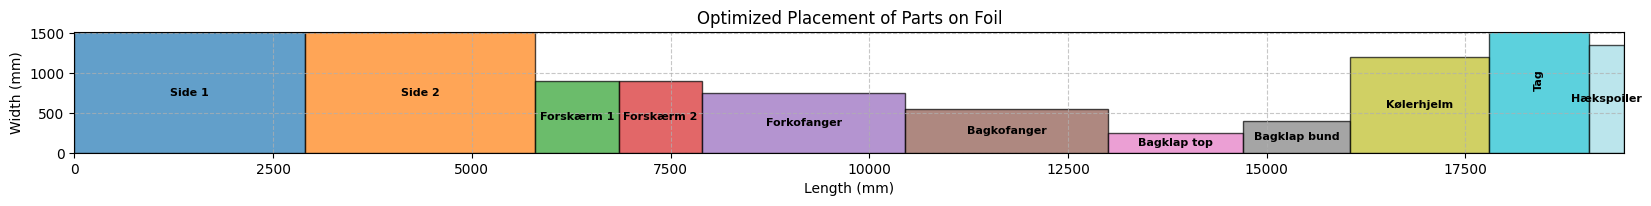


Results:
Total area of parts: 20006000.00 square millimeters
Initial estimated length: 14479 mm
Actual used length: 19500 mm
Total waste: 9634000.00 square millimeters
Waste percentage: 32.50%

Optimized placement of parts:
Side 1: (0, 0) to (2900, 1520)
Side 2: (2900, 0) to (5800, 1520)
Forskærm 1: (5800, 0) to (6850, 900)
Forskærm 2: (6850, 0) to (7900, 900)
Forkofanger: (7900, 0) to (10450, 750)
Bagkofanger: (10450, 0) to (13000, 550)
Bagklap top: (13000, 0) to (14700, 250)
Bagklap bund: (14700, 0) to (16050, 400)
Kølerhjelm: (16050, 0) to (17800, 1200)
Tag: (17800, 0) to (19050, 1850) (rotated)
Hækspoiler: (19050, 0) to (19500, 1350)


In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

# Definerer rektangelklassen
class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

    def area(self):
        return self.width * self.height

    def __repr__(self):
        return f"{self.name}: ({self.width}x{self.height})"

# Kontrollerer om et rektangel kan placeres på et givent sted
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

# Placerer et rektangel på det bedste mulige sted
def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

# Håndterer `Bagklap top` og `Bagklap bund`, placerer dem ovenpå hinanden
def handle_bagklap(dele):
    bagklap_top = None
    bagklap_bund = None

    for i, (name, length, width) in enumerate(dele):
        if name == "Bagklap top":
            bagklap_top = Rectangle(length, width, name)
        elif name == "Bagklap bund":
            bagklap_bund = Rectangle(length, width, name)

    if bagklap_top and bagklap_bund and bagklap_top.width == bagklap_bund.width:
        # Forsøg at placere Bagklap top og Bagklap bund ovenpå hinanden
        bagklap_top.y = 0
        bagklap_bund.y = bagklap_top.height

        dele.remove(("Bagklap top", bagklap_top.width, bagklap_top.height))
        dele.remove(("Bagklap bund", bagklap_bund.width, bagklap_bund.height))
        dele.append(("Bagklap", bagklap_top.width, bagklap_top.height + bagklap_bund.height))

    return dele

# Ny funktion til at pakke dele med stabling
def pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        if not place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
            # Hvis det ikke lykkes at placere ved siden af hinanden, prøv at stable
            placed = False
            for placed_rect in placed_rects:
                if place_on_top(placed_rect, rect, placed_rects, folie_bredde, folie_længde):
                    placed = True
                    break
            if not placed:
                return None
    return placed_rects

# Placerer et rektangel ovenpå et andet rektangel
def place_on_top(base_rect, rect, placed_rects, folie_bredde, folie_længde):
    x = base_rect.x
    y = base_rect.y + base_rect.height
    if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
        rect.x, rect.y = x, y
        rect.rotated = False  # Sørg for, at rektanglet ikke er roteret
        placed_rects.append(rect)
        return True
    return False

# Plotter placeringen af rektanglerne
def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    cmap = plt.colormaps['tab20']  # Opdateret til ny metode i Matplotlib 3.7
    colors = cmap(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Simulated Annealing algoritmen til at optimere pakningen
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    # Initial solution
    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles_with_stacking(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Genetisk algoritme til at optimere pakningen
def genetic_algorithm(dele, folie_bredde, folie_længde, population_size=100, generations=100, mutation_rate=0.1):
    def create_individual():
        rectangles = [Rectangle(length, width, name) for name, length, width in dele]
        random.shuffle(rectangles)
        return rectangles

    def fitness_function(rectangles):
        packing = pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    def crossover(parent1, parent2):
        split = random.randint(1, len(parent1) - 1)
        return parent1[:split] + parent2[split:]

    def mutate(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    population = [create_individual() for _ in range(population_size)]
    best_length = float('inf')
    best_packing = None

    for _ in range(generations):
        population.sort(key=fitness_function)
        if fitness_function(population[0]) < best_length:
            best_length = fitness_function(population[0])
            best_packing = pack_rectangles_with_stacking(population[0], folie_bredde, folie_længde)

        new_population = population[:2]  # Keep the best two

        for _ in range(population_size - 2):
            parent1, parent2 = random.choices(population[:10], k=2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child)
            new_population.append(child)

        population = new_population

    return best_packing, best_length

# Tabu Search algoritmen til at optimere pakningen
def tabu_search(dele, folie_bredde, folie_længde, max_iterations=1000, tabu_size=10):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def neighborhood_solution(solution):
        neighbor = solution.copy()
        random_swap(neighbor)
        return neighbor

    def fitness_function(rectangles):
        packing = pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    tabu_list = []

    for iteration in range(max_iterations):
        neighbor = neighborhood_solution(current_solution)
        neighbor_fitness = fitness_function(neighbor)

        if neighbor_fitness < best_fitness:
            best_fitness = neighbor_fitness
            best_solution = neighbor.copy()

        if len(tabu_list) >= tabu_size:
            tabu_list.pop(0)
        tabu_list.append(current_solution)

        if neighbor not in tabu_list:
            current_solution = neighbor
            current_fitness = neighbor_fitness

    best_packing = pack_rectangles_with_stacking(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Opdatering af `dele` listen
dele = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350)
]

# Håndterer Bagklap top og Bagklap bund
dele = handle_bagklap(dele)

# Beregner den initiale anslåede længde af folien
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimering af pakning ved hjælp af Simulated Annealing
best_packing, used_length = simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

else:
    print("Failed to find a valid packing arrangement.")


Initial estimated foil length: 10013 mm


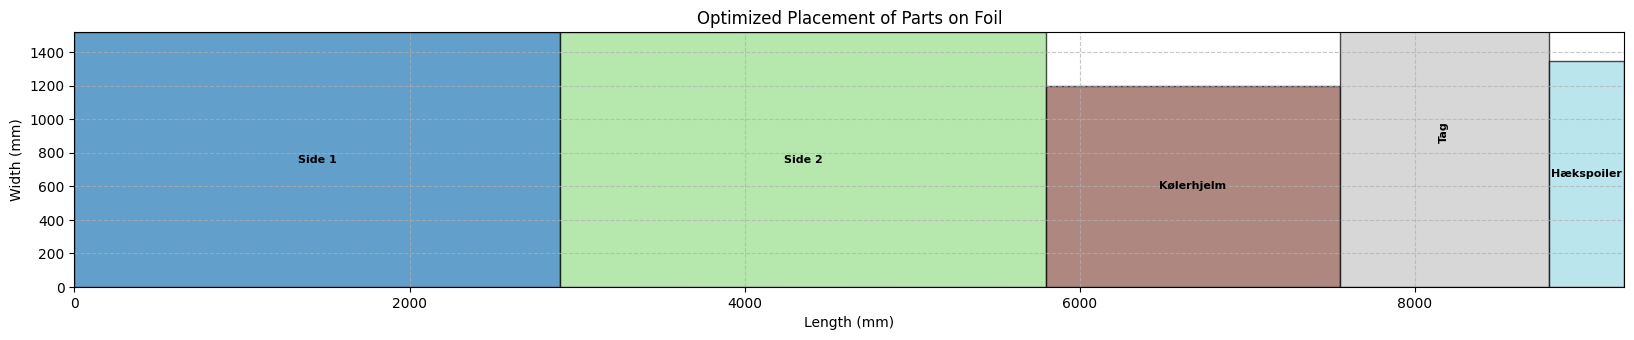


Results:
Total area of parts: 13836000.00 square millimeters
Initial estimated length: 10013 mm
Actual used length: 9250 mm
Total waste: 224000.00 square millimeters
Waste percentage: 1.59%

Optimized placement of parts:
Side 1: (0, 0) to (2900, 1520)
Side 2: (2900, 0) to (5800, 1520)
Kølerhjelm: (5800, 0) to (7550, 1200)
Tag: (7550, 0) to (8800, 1850) (rotated)
Hækspoiler: (8800, 0) to (9250, 1350)


In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

# Definerer rektangelklassen
class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

    def area(self):
        return self.width * self.height

    def __repr__(self):
        return f"{self.name}: ({self.width}x{self.height})"

# Kontrollerer om et rektangel kan placeres på et givent sted
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

# Placerer et rektangel på det bedste mulige sted
def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

# Håndterer `Bagklap top` og `Bagklap bund`, placerer dem ovenpå hinanden
def handle_bagklap(dele):
    bagklap_top = None
    bagklap_bund = None

    for i, (name, length, width) in enumerate(dele):
        if name == "Bagklap top":
            bagklap_top = Rectangle(length, width, name)
        elif name == "Bagklap bund":
            bagklap_bund = Rectangle(length, width, name)

    if bagklap_top and bagklap_bund and bagklap_top.width == bagklap_bund.width:
        # Forsøg at placere Bagklap top og Bagklap bund ovenpå hinanden
        bagklap_top.y = 0
        bagklap_bund.y = bagklap_top.height

        dele.remove(("Bagklap top", bagklap_top.width, bagklap_top.height))
        dele.remove(("Bagklap bund", bagklap_bund.width, bagklap_bund.height))
        dele.append(("Bagklap", bagklap_top.width, bagklap_top.height + bagklap_bund.height))

    return dele

# Ny funktion til at pakke dele med stabling
def pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        if not place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
            # Hvis det ikke lykkes at placere ved siden af hinanden, prøv at stable
            placed = False
            for placed_rect in placed_rects:
                if place_on_top(placed_rect, rect, placed_rects, folie_bredde, folie_længde):
                    placed = True
                    break
            if not placed:
                return None
    return placed_rects

# Placerer et rektangel ovenpå et andet rektangel
def place_on_top(base_rect, rect, placed_rects, folie_bredde, folie_længde):
    x = base_rect.x
    y = base_rect.y + base_rect.height
    if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
        rect.x, rect.y = x, y
        rect.rotated = False  # Sørg for, at rektanglet ikke er roteret
        placed_rects.append(rect)
        return True
    return False

# Plotter placeringen af rektanglerne
def plot_packing(packing, folie_bredde, folie_længde):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    cmap = plt.colormaps['tab20']  # Opdateret til ny metode i Matplotlib 3.7
    colors = cmap(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title('Optimized Placement of Parts on Foil')
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Simulated Annealing algoritmen til at optimere pakningen
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    # Initial solution
    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles_with_stacking(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Opdatering af `dele` listen
dele = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350),
]

mindredele = [
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
]

# Håndterer Bagklap top og Bagklap bund
dele = handle_bagklap(dele)

# Beregner den initiale anslåede længde af folien
total_area = sum(length * width for _, length, width in dele)
initial_estimate = int(np.ceil((total_area / folie_bredde) * 1.1))
print(f"Initial estimated foil length: {initial_estimate} mm")

# Optimering af pakning ved hjælp af Simulated Annealing
best_packing, used_length = simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

if best_packing:
    plot_packing(best_packing, folie_bredde, used_length)

    total_dele_areal = sum(rect.width * rect.height for rect in best_packing)
    used_area = folie_bredde * used_length
    waste_area = used_area - total_dele_areal
    waste_percent = (waste_area / used_area) * 100

    print("\nResults:")
    print(f"Total area of parts: {total_dele_areal:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate} mm")
    print(f"Actual used length: {used_length} mm")
    print(f"Total waste: {waste_area:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent:.2f}%")

    print("\nOptimized placement of parts:")
    for rect in best_packing:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

else:
    print("Failed to find a valid packing arrangement.")


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import math

# Definerer rektangelklassen
class Rectangle:
    def __init__(self, width, height, name):
        self.width = width
        self.height = height
        self.name = name
        self.x = 0
        self.y = 0
        self.rotated = False

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated

    def area(self):
        return self.width * self.height

    def __repr__(self):
        return f"{self.name}: ({self.width}x{self.height})"

# Kontrollerer om et rektangel kan placeres på et givent sted
def can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
    if x + rect.width > folie_længde or y + rect.height > folie_bredde:
        return False
    for placed in placed_rects:
        if (x < placed.x + placed.width and x + rect.width > placed.x and
            y < placed.y + placed.height and y + rect.height > placed.y):
            return False
    return True

# Placerer et rektangel på det bedste mulige sted
def place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
    best_x = folie_længde
    best_y = folie_bredde
    best_rotation = False
    best_placement = None
    placed = False

    for rotated in [False, True]:
        if rotated:
            rect.rotate()
        for placed_rect in placed_rects + [Rectangle(0, 0, "bottom")]:
            for (x, y) in [(placed_rect.x + placed_rect.width, placed_rect.y),
                          (placed_rect.x, placed_rect.y + placed_rect.height)]:
                if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
                    if y < best_y or (y == best_y and x < best_x):
                        best_x, best_y = x, y
                        best_rotation = rotated
                        best_placement = (x, y)
                        placed = True

        if rotated:
            rect.rotate()

    if placed:
        rect.x, rect.y = best_placement
        rect.rotated = best_rotation
        placed_rects.append(rect)
    return placed

# Håndterer `Bagklap top` og `Bagklap bund`, placerer dem ovenpå hinanden
def handle_bagklap(dele):
    bagklap_top = None
    bagklap_bund = None

    for i, (name, length, width) in enumerate(dele):
        if name == "Bagklap top":
            bagklap_top = Rectangle(length, width, name)
        elif name == "Bagklap bund":
            bagklap_bund = Rectangle(length, width, name)

    if bagklap_top and bagklap_bund and bagklap_top.width == bagklap_bund.width:
        # Forsøg at placere Bagklap top og Bagklap bund ovenpå hinanden
        bagklap_top.y = 0
        bagklap_bund.y = bagklap_top.height

        dele.remove(("Bagklap top", bagklap_top.width, bagklap_top.height))
        dele.remove(("Bagklap bund", bagklap_bund.width, bagklap_bund.height))
        dele.append(("Bagklap", bagklap_top.width, bagklap_top.height + bagklap_bund.height))

    return dele

# Ny funktion til at pakke dele med stabling
def pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde):
    placed_rects = []
    for rect in rectangles:
        if not place_rectangle(rect, placed_rects, folie_bredde, folie_længde):
            # Hvis det ikke lykkes at placere ved siden af hinanden, prøv at stable
            placed = False
            for placed_rect in placed_rects:
                if place_on_top(placed_rect, rect, placed_rects, folie_bredde, folie_længde):
                    placed = True
                    break
            if not placed:
                return None
    return placed_rects

# Placerer et rektangel ovenpå et andet rektangel
def place_on_top(base_rect, rect, placed_rects, folie_bredde, folie_længde):
    x = base_rect.x
    y = base_rect.y + base_rect.height
    if can_place(rect, x, y, placed_rects, folie_bredde, folie_længde):
        rect.x, rect.y = x, y
        rect.rotated = False  # Sørg for, at rektanglet ikke er roteret
        placed_rects.append(rect)
        return True
    return False

# Plotter placeringen af rektanglerne
def plot_packing(packing, folie_bredde, folie_længde, title):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, folie_længde)
    ax.set_ylim(0, folie_bredde)
    ax.set_aspect('equal')

    cmap = plt.colormaps['tab20']  # Opdateret til ny metode i Matplotlib 3.7
    colors = cmap(np.linspace(0, 1, len(packing)))

    for rect, color in zip(packing, colors):
        r = patches.Rectangle((rect.x, rect.y), rect.width, rect.height,
                              edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(r)
        rx, ry = r.get_xy()
        cx = rx + r.get_width()/2.0
        cy = ry + r.get_height()/2.0
        ax.annotate(rect.name, (cx, cy), color='black', weight='bold',
                    fontsize=8, ha='center', va='center', rotation=90 if rect.rotated else 0)

    plt.title(title)
    plt.xlabel('Length (mm)')
    plt.ylabel('Width (mm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Simulated Annealing algoritmen til at optimere pakningen
def simulated_annealing(dele, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000):
    def random_swap(rectangles):
        idx1, idx2 = random.sample(range(len(rectangles)), 2)
        rectangles[idx1], rectangles[idx2] = rectangles[idx2], rectangles[idx1]

    def temperature_schedule(t):
        return t * cooling_rate

    def fitness_function(rectangles):
        packing = pack_rectangles_with_stacking(rectangles, folie_bredde, folie_længde)
        if packing:
            return max(rect.x + rect.width for rect in packing)
        return float('inf')

    # Initial solution
    current_solution = [Rectangle(length, width, name) for name, length, width in dele]
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    temperature = initial_temperature
    for iteration in range(max_iterations):
        new_solution = current_solution.copy()
        random_swap(new_solution)
        new_fitness = fitness_function(new_solution)

        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution.copy()

        delta_fitness = current_fitness - new_fitness
        if delta_fitness > 0 or random.random() < math.exp(delta_fitness / temperature):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

        temperature = temperature_schedule(temperature)

    best_packing = pack_rectangles_with_stacking(best_solution, folie_bredde, folie_længde)
    return best_packing, best_fitness

# Grupper af dele
gruppe1 = [
    ("Side 1", 2900, 1520),
    ("Side 2", 2900, 1520),
    ("Kølerhjelm", 1750, 1200),
    ("Tag", 1250, 1850),
    ("Hækspoiler", 450, 1350),
]

gruppe2 = [
    ("Forskærm 1", 1050, 900),
    ("Forskærm 2", 1050, 900),
    ("Forkofanger", 2550, 750),
    ("Bagkofanger", 2550, 550),
    ("Bagklap top", 1700, 250),
    ("Bagklap bund", 1350, 400),
]

# Håndterer Bagklap top og Bagklap bund i Gruppe 2
gruppe2 = handle_bagklap(gruppe2)

# Beregner den initiale anslåede længde af folien for Gruppe 1 og Gruppe 2
total_area1 = sum(length * width for _, length, width in gruppe1)
total_area2 = sum(length * width for _, length, width in gruppe2)
initial_estimate1 = int(np.ceil((total_area1 / folie_bredde) * 1.1))
initial_estimate2 = int(np.ceil((total_area2 / folie_bredde) * 1.1))
print(f"Initial estimated foil length for Group 1: {initial_estimate1} mm")
print(f"Initial estimated foil length for Group 2: {initial_estimate2} mm")

# Optimering af pakning for Gruppe 1
best_packing1, used_length1 = simulated_annealing(gruppe1, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

# Optimering af pakning for Gruppe 2
best_packing2, used_length2 = simulated_annealing(gruppe2, folie_bredde, folie_længde, initial_temperature=1000, cooling_rate=0.995, max_iterations=1000)

if best_packing1 and best_packing2:
    plot_packing(best_packing1, folie_bredde, used_length1, "Optimized Placement for Group 1")
    plot_packing(best_packing2, folie_bredde, used_length2, "Optimized Placement for Group 2")

    total_dele_areal1 = sum(rect.width * rect.height for rect in best_packing1)
    total_dele_areal2 = sum(rect.width * rect.height for rect in best_packing2)
    used_area1 = folie_bredde * used_length1
    used_area2 = folie_bredde * used_length2
    waste_area1 = used_area1 - total_dele_areal1
    waste_area2 = used_area2 - total_dele_areal2
    waste_percent1 = (waste_area1 / used_area1) * 100
    waste_percent2 = (waste_area2 / used_area2) * 100

    print("\nResults for Group 1:")
    print(f"Total area of parts: {total_dele_areal1:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate1} mm")
    print(f"Actual used length: {used_length1} mm")
    print(f"Total waste: {waste_area1:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent1:.2f}%")

    print("\nResults for Group 2:")
    print(f"Total area of parts: {total_dele_areal2:.2f} square millimeters")
    print(f"Initial estimated length: {initial_estimate2} mm")
    print(f"Actual used length: {used_length2} mm")
    print(f"Total waste: {waste_area2:.2f} square millimeters")
    print(f"Waste percentage: {waste_percent2:.2f}%")

    print("\nOptimized placement of parts for Group 1:")
    for rect in best_packing1:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

    print("\nOptimized placement of parts for Group 2:")
    for rect in best_packing2:
        print(f"{rect.name}: ({rect.x}, {rect.y}) to ({rect.x + rect.width}, {rect.y + rect.height}){' (rotated)' if rect.rotated else ''}")

else:
    print("Failed to find a valid packing arrangement for one or both groups.")


NameError: name 'folie_bredde' is not defined